In [1]:
import warnings

import numpy as np
import rasterio
import geopandas as gpd
import pandas as pd
from shapely.geometry import *
from shapely.errors import ShapelyDeprecationWarning
import shapely.affinity
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["font.family"] = "Arial"

from scrollstats import BendDataset, calculate_ridge_metrics

In [2]:
def join_packet_info(itx, packets):

    itx_packets = itx.copy()

    itx_packets = itx_packets.sjoin(packets.drop("bend_id", axis=1))
    itx_packets = itx_packets.reset_index().set_index(["packet_id", "transect_id", "ridge_id"])

    return itx_packets

In [3]:
def calc_component_geometries(in_gdf):

    gdf = in_gdf.copy()

    def calc_x_comp_geometry(point, x_comp):
        x_s, y_s = point.coords[0]
        return LineString([point, Point(x_s+x_comp, y_s)])
    
    def calc_y_comp_geometry(point, y_comp):
        x_s, y_s = point.coords[0]
        return LineString([point, Point(x_s, y_s+y_comp)])

    # Calc component distances
    gdf["x_comp_distance"] = gdf["pre_mig_geometry"].apply(lambda l: np.diff(l.xy)[0][0])
    gdf["y_comp_distance"] = gdf["pre_mig_geometry"].apply(lambda l: np.diff(l.xy)[1][0])

    # Calc component geometries
    gdf["x_comp_geometry"] = gdf[["geometry", "x_comp_distance"]].apply(lambda x: calc_x_comp_geometry(*x), axis=1)
    gdf["y_comp_geometry"] = gdf[["geometry", "y_comp_distance"]].apply(lambda x: calc_y_comp_geometry(*x), axis=1)

    # Return new gdf
    return gdf

In [4]:
def calc_mean_comp_distances(in_packets, itx_packets):
    packets = in_packets.copy()

    mean_comp_distances = itx_packets[["x_comp_distance", "y_comp_distance"]].groupby(level=0).agg("mean")
    packets_mean_comp = packets.set_index("packet_id").join(mean_comp_distances)

    return packets_mean_comp


In [5]:
def calc_mean_comp_geometry(point, x_comp, y_comp):
    """
    Used to calculate a LineString representation of the mean component geometry from mean comp distances and a start point.
    Designed for ues with a lambda statement
    """
    x_s, y_s = point.coords[0]
    ls = LineString([point, Point(x_s-x_comp, y_s-y_comp)])
    scaled_ls = shapely.affinity.scale(ls, 5, 5, origin=point)
    return scaled_ls

In [6]:
def violin_data(itx_packets):
    """
    Returns is a dictionary that will contain the each metric above as a top-level key, 
        all packet ids as sublevel keys, 
            and arrays of ridge metrics where each element represents the value at an intersection
    """
    
    sorted_packet_ids = itx_packets.index.get_level_values(0).unique().sort_values(ascending=False).values
    metric_names = ["ridge_amp", "ridge_width", "pre_mig_dist"]

    ridge_metrics = {}
    for name in metric_names:
        d = {}
        for p_id in sorted_packet_ids:
            vals = itx_packets.loc[p_id, name].values
            vals = np.delete(vals, np.isnan(vals))
            d[p_id] = vals
        
        ridge_metrics[name] = d

    return ridge_metrics

## Create bend dataset for LBR_025

In [7]:
bend_id = "LBR_025"
dem = rasterio.open("/Users/avan/FLUD/BrazosScrolls/data/raster/dem/sb_1_025_clip.tif")
bin_raster = rasterio.open("/Users/avan/FLUD/BrazosScrolls/data/r10/agreement-clip-denoise/sb_1_025_agreement_45px_binclass_clip_dn_Buff100m_SmFt500m_ET80p.tif")

bend_ds = BendDataset(bend_id)
transects = bend_ds.get_transects(proj=True)
ridges = bend_ds.get_ridges(proj=True)
packets = bend_ds.get_packets(proj=True)
packets["centroid"] = packets.centroid



## Calc Transect metrics

In [8]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", ShapelyDeprecationWarning)
    rich_transects, itx = calculate_ridge_metrics(transects, bin_raster, dem, ridges)

# Additional processes that need to be integrated upstream
itx = itx.droplevel(0)
itx["pre_mig_geometry"] = itx["substring_geometry"].apply(lambda x: LineString(x.coords[1:]))
itx_packets = join_packet_info(itx, packets)
itx_packets = calc_component_geometries(itx_packets)
packets = calc_mean_comp_distances(packets, itx_packets)


Started BDE
Started TDE for t_009
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_010
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_011
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_012
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_013
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_014
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_015
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_016
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started 

/Users/avan/opt/miniconda3/envs/scroll/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/avan/opt/miniconda3/envs/scroll/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [9]:
itx_packets.head()


start_distances  \
packet_id transect_id ridge_id                    
p_04      t_009       r_002          196.690242   
                      r_018          116.059707   
                      r_019            0.000000   
                      r_020          139.628971   
                      r_021          153.960057   

                                                        relative_vertex_distances  \
packet_id transect_id ridge_id                                                      
p_04      t_009       r_002     [0.37701965565340345, 0.4924274886323948, 0.65...   
                      r_018     [0.2224654890271171, 0.2676435093499922, 0.295...   
                      r_019         [0.0, 0.2224654890271171, 0.2676435093499922]   
                      r_020     [0.2676435093499922, 0.2951136129359185, 0.377...   
                      r_021     [0.2951136129359185, 0.37701965565340345, 0.49...   

                                 vertex_indices  \
packet_id transect_id ridge_id                    
p_04      t_009       r_002     [197, 257, 344]   
                      r_018     [116, 140, 154]   
                      r_019       [0, 116, 140]   
                      r_020     [140, 154, 197]   
                      r_021     [154, 197, 257]   

                                                                       dem_signal  \
packet_id transect_id ridge_id                                                      
p_04      t_009       r_002     [67.69518280029297, 67.68385314941406, 67.7053...   
                      r_018     [66.78546905517578, 67.00314331054688, 67.0151...   
                      r_019     [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
                      r_020     [68.31480407714844, 68.37470245361328, 68.3506...   
                      r_021     [68.46773529052734, 68.45271301269531, 68.3821...   

                                                                       bin_signal  \
packet_id transect_id ridge_id                                                      
p_04      t_009       r_002     [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
                      r_018     [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
                      r_019     [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
                      r_020     [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
                      r_021     [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...   

                                pre_mig_dist  post_mig_dist  pre_mig_time  \
packet_id transect_id ridge_id                                              
p_04      t_009       r_002        87.040274      60.207987           NaN   
                      r_018        14.331087      23.569264           NaN   
                      r_019        23.569264     116.059707           NaN   
                      r_020        42.730184      14.331087           NaN   
                      r_021        60.207987      42.730184           NaN   

                                post_mig_time  pre_mig_rate  ...  \
packet_id transect_id ridge_id                               ...   
p_04      t_009       r_002               NaN           NaN  ...   
                      r_018               NaN           NaN  ...   
                      r_019               NaN           NaN  ...   
                      r_020               NaN           NaN  ...   
                      r_021               NaN           NaN  ...   

                                deposit_year  \
packet_id transect_id ridge_id                 
p_04      t_009       r_002              NaN   
                      r_018              NaN   
                      r_019              NaN   
                      r_020              NaN   
                      r_021              NaN   

                                                               substring_geometry  \
packet_id transect_id ridge_id                                                      
p_04

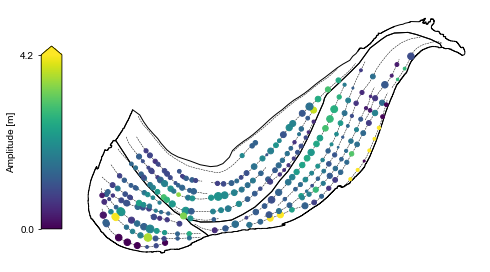

In [10]:
fig = plt.figure(figsize=(10,8))
gs = GridSpec(4,5, figure=fig)

# Main Itx Plot
vmin = 0
vmax = 4.2

## Create Colorbar
ax1 = fig.add_subplot(gs[1:, :4])
divider = make_axes_locatable(ax1)
cax = divider.append_axes("left", size="5%", pad=0.1, aspect=2)

## Plot itx and ridges
itx.plot(ax=ax1, column="ridge_amp", markersize="ridge_width", vmin=vmin, vmax=vmax, legend=True, cax=cax, legend_kwds={"extend":"max"})
ridges.plot(ax=ax1, color="k", ls="--", lw=0.5, zorder=0)
packets.boundary.plot(ax=ax1, color="k", lw=1, zorder=0)

cax.set_yticks([vmin, vmax])
cax.set_ylabel("Amplitude [m]")

cax.yaxis.set_ticks_position('left')
cax.yaxis.set_label_position('left')

ax1.set_axis_off()

# Add box plots for each transect

## Make violin plot

- Unstacking the packet info causes the kernal to crash
    - So we need to achieve the sam effect with loops

/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_53659/371854471.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  vals = itx_packets.loc[p_id, name].values
/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_53659/371854471.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  vals = itx_packets.loc[p_id, name].values
/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_53659/371854471.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  vals = itx_packets.loc[p_id, name].values
/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_53659/371854471.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  vals = itx_packets.loc[p_id, name].values
/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_53659/371854471.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  vals = itx_packets.loc[p_id, name].values
/var/folde

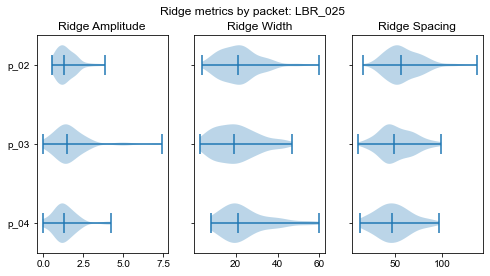

In [11]:
ridge_metrics = violin_data(itx_packets)
sorted_packet_ids = itx_packets.index.get_level_values(0).unique().sort_values(ascending=False).values

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 4))

# Plot 1 - Amps
ax1.violinplot([ridge_metrics["ridge_amp"][i] for i in sorted_packet_ids], vert=False, showmedians=True)

ax1.set_yticks(range(1, 4))
ax1.set_yticklabels(sorted_packet_ids)
ax1.set_title("Ridge Amplitude")

# Plot 2 - Width
ax2.violinplot([ridge_metrics["ridge_width"][i] for i in sorted_packet_ids], vert=False, showmedians=True)

ax2.set_yticks(range(1, 4))
ax2.set_yticklabels([])
ax2.set_title("Ridge Width")

# Plot 1 - Amps
ax3.violinplot([ridge_metrics["pre_mig_dist"][i] for i in sorted_packet_ids], vert=False, showmedians=True)

ax3.set_yticks(range(1, 4))
ax3.set_yticklabels([])
ax3.set_title("Ridge Spacing")
plt.suptitle(f"Ridge metrics by packet: {bend_id}")
plt.savefig(f"/Users/avan/FLUD/BrazosScrolls/figures/RidgeMetricsWithinPackets_{bend_id}.png", dpi=200)

## Find the directional variaiton within packets

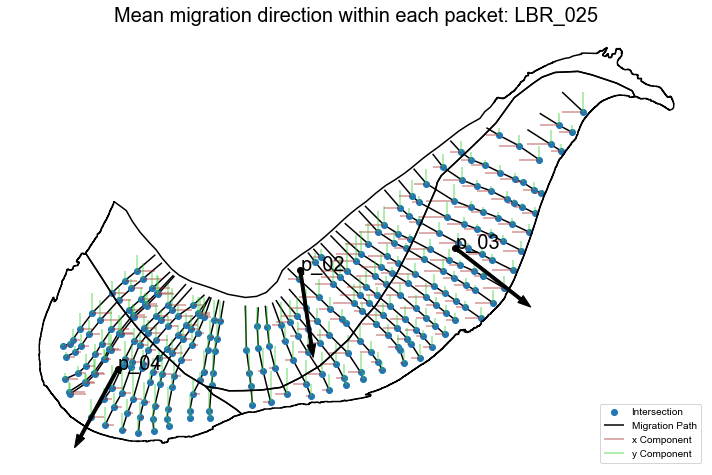

In [12]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

# Plot points and thier component directions
itx_packets.plot(ax=ax, zorder=2, label="Intersection")
itx_packets.set_geometry("pre_mig_geometry").plot(ax=ax, color="k", zorder=1, label="Migration Path")
itx_packets.set_geometry("x_comp_geometry").plot(ax=ax, color="brown", alpha=0.5, label="x Component")
itx_packets.set_geometry("y_comp_geometry").plot(ax=ax, color="limegreen", alpha=0.5, label="y Component")

# Plot packets
packets.boundary.plot(ax=ax, color="k")
packets.set_geometry("centroid").plot(ax=ax, color="k", zorder=3)

# Plot arrows showing the mean component direction
for i, row in packets.iterrows():
    x, y = row["centroid"].coords[0]
    plt.arrow(x, y, -row["x_comp_distance"]*5, -row["y_comp_distance"]*5, width=9, color="k", zorder=3)

# Plot packet labels
for idx, row in packets.iterrows():
    plt.annotate(text=idx, xy=row["centroid"].coords[0],
                 horizontalalignment='left', size=20)

ax.set_title(f"Mean migration direction within each packet: {bend_id}", size=20)
ax.legend(loc="lower right")
ax.set_axis_off()
plt.tight_layout()
plt.savefig(f"/Users/avan/FLUD/BrazosScrolls/figures/MigrationDirectionWithinPackets_{bend_id}.png", dpi=200)

## LBR_029

In [13]:
bend_id = "LBR_029"
dem = rasterio.open("/Users/avan/FLUD/BrazosScrolls/data/raster/dem/sb_1_029_clip.tif")
bin_raster = rasterio.open("/Users/avan/FLUD/BrazosScrolls/data/r10/agreement-clip-denoise/sb_1_029_agreement_45px_binclass_clip_dn_Buff100m_SmFt500m_ET80p.tif")

bend_ds = BendDataset(bend_id)
transects = bend_ds.get_transects(proj=True)
ridges = bend_ds.get_ridges(proj=True)
packets = bend_ds.get_packets(proj=True)
packets["centroid"] = packets.centroid


In [14]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", ShapelyDeprecationWarning)
    rich_transects, itx = calculate_ridge_metrics(transects, bin_raster, dem, ridges)

# Additional processes that need to be integrated upstream
itx = itx.droplevel(0)
itx["pre_mig_geometry"] = itx["substring_geometry"].apply(lambda x: LineString(x.coords[1:]))
itx_packets = join_packet_info(itx, packets)
itx_packets = calc_component_geometries(itx_packets)
packets = calc_mean_comp_distances(packets, itx_packets)


Started BDE
Started TDE for t_003
Started TDE for t_004
Started TDE for t_005
Started TDE for t_006
Started RDE
Started TDE for t_007
Started RDE
Started TDE for t_008
Started RDE
Started TDE for t_009
Started RDE
Started RDE
Started TDE for t_010
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_011
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_012
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_013
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_014
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_015
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_016
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_017
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RD

/Users/avan/opt/miniconda3/envs/scroll/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/avan/opt/miniconda3/envs/scroll/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


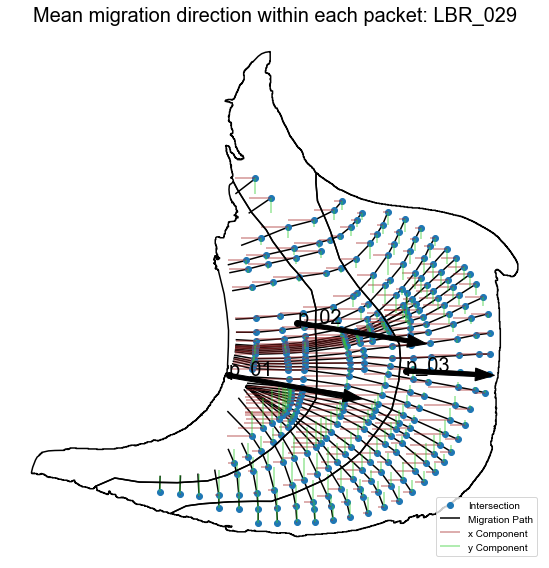

In [15]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

# Plot points and thier component directions
itx_packets.plot(ax=ax, zorder=2, label="Intersection")
itx_packets.set_geometry("pre_mig_geometry").plot(ax=ax, color="k", zorder=1, label="Migration Path")
itx_packets.set_geometry("x_comp_geometry").plot(ax=ax, color="brown", alpha=0.5, label="x Component")
itx_packets.set_geometry("y_comp_geometry").plot(ax=ax, color="limegreen", alpha=0.5, label="y Component")

# Plot packets
packets.boundary.plot(ax=ax, color="k")
packets.set_geometry("centroid").plot(ax=ax, color="k", zorder=3)

# Plot arrows showing the mean component direction
for i, row in packets.iterrows():
    x, y = row["centroid"].coords[0]
    plt.arrow(x, y, -row["x_comp_distance"]*5, -row["y_comp_distance"]*5, width=9, color="k", zorder=3)

# Plot packet labels
for idx, row in packets.iterrows():
    plt.annotate(text=idx, xy=row["centroid"].coords[0],
                 horizontalalignment='left', size=20)

ax.set_title(f"Mean migration direction within each packet: {bend_id}", size=20)
ax.legend(loc="lower right")
ax.set_axis_off()
plt.tight_layout()
plt.savefig(f"/Users/avan/FLUD/BrazosScrolls/figures/MigrationDirectionWithinPackets_{bend_id}.png", dpi=200)

### Violin plots

/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_53659/371854471.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  vals = itx_packets.loc[p_id, name].values
/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_53659/371854471.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  vals = itx_packets.loc[p_id, name].values
/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_53659/371854471.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  vals = itx_packets.loc[p_id, name].values
/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_53659/371854471.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  vals = itx_packets.loc[p_id, name].values
/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_53659/371854471.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  vals = itx_packets.loc[p_id, name].values
/var/folde

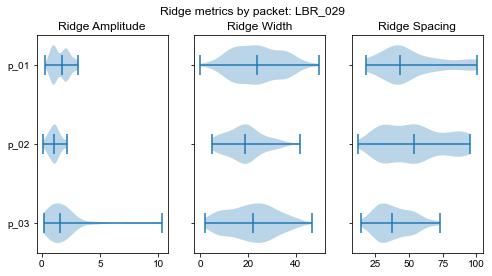

In [16]:
ridge_metrics = violin_data(itx_packets)
sorted_packet_ids = itx_packets.index.get_level_values(0).unique().sort_values(ascending=False).values

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 4))

# Plot 1 - Amps
ax1.violinplot([ridge_metrics["ridge_amp"][i] for i in sorted_packet_ids], vert=False, showmedians=True)

ax1.set_yticks(range(1, 4))
ax1.set_yticklabels(sorted_packet_ids)
ax1.set_title("Ridge Amplitude")

# Plot 2 - Width
ax2.violinplot([ridge_metrics["ridge_width"][i] for i in sorted_packet_ids], vert=False, showmedians=True)

ax2.set_yticks(range(1, 4))
ax2.set_yticklabels([])
ax2.set_title("Ridge Width")

# Plot 1 - Amps
ax3.violinplot([ridge_metrics["pre_mig_dist"][i] for i in sorted_packet_ids], vert=False, showmedians=True)

ax3.set_yticks(range(1, 4))
ax3.set_yticklabels([])
ax3.set_title("Ridge Spacing")
plt.suptitle(f"Ridge metrics by packet: {bend_id}")
plt.savefig(f"/Users/avan/FLUD/BrazosScrolls/figures/RidgeMetricsWithinPackets_{bend_id}.png", dpi=200)

## LBR_043

In [17]:
bend_id = "LBR_043"
dem = rasterio.open("/Users/avan/FLUD/BrazosScrolls/data/raster/dem/sb_1_043_clip.tif")
bin_raster = rasterio.open("/Users/avan/FLUD/BrazosScrolls/data/r10/agreement-clip-denoise/sb_1_043_agreement_45px_binclass_clip_dn_Buff100m_SmFt500m_ET80p.tif")

bend_ds = BendDataset(bend_id)
transects = bend_ds.get_transects(proj=True)
ridges = bend_ds.get_ridges(proj=True)
packets = bend_ds.get_packets(proj=True)
packets["centroid"] = packets.centroid


In [18]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", ShapelyDeprecationWarning)
    rich_transects, itx = calculate_ridge_metrics(transects, bin_raster, dem, ridges)

# Additional processes that need to be integrated upstream
itx = itx.droplevel(0)
itx["pre_mig_geometry"] = itx["substring_geometry"].apply(lambda x: LineString(x.coords[1:]))
itx_packets = join_packet_info(itx, packets)
itx_packets = calc_component_geometries(itx_packets)
packets = calc_mean_comp_distances(packets, itx_packets)

Started BDE
Started TDE for t_047
Started TDE for t_048
Started TDE for t_016
Started RDE
Started TDE for t_017
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_018
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_019
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_020
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_021
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_022
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RD

/Users/avan/opt/miniconda3/envs/scroll/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/avan/opt/miniconda3/envs/scroll/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


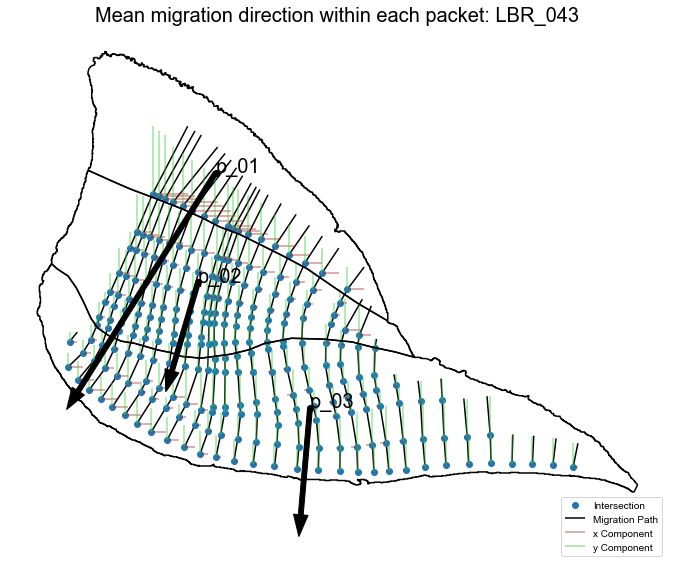

In [19]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

# Plot points and thier component directions
itx_packets.plot(ax=ax, zorder=2, label="Intersection")
itx_packets.set_geometry("pre_mig_geometry").plot(ax=ax, color="k", zorder=1, label="Migration Path")
itx_packets.set_geometry("x_comp_geometry").plot(ax=ax, color="brown", alpha=0.5, label="x Component")
itx_packets.set_geometry("y_comp_geometry").plot(ax=ax, color="limegreen", alpha=0.5, label="y Component")

# Plot packets
packets.boundary.plot(ax=ax, color="k")
packets.set_geometry("centroid").plot(ax=ax, color="k", zorder=3)

# Plot arrows showing the mean component direction
for i, row in packets.iterrows():
    x, y = row["centroid"].coords[0]
    plt.arrow(x, y, -row["x_comp_distance"]*5, -row["y_comp_distance"]*5, width=9, color="k", zorder=3)

# Plot packet labels
for idx, row in packets.iterrows():
    plt.annotate(text=idx, xy=row["centroid"].coords[0],
                 horizontalalignment='left', size=20)

ax.set_title(f"Mean migration direction within each packet: {bend_id}", size=20)
ax.legend(loc="lower right")
ax.set_axis_off()
plt.tight_layout()
plt.savefig(f"/Users/avan/FLUD/BrazosScrolls/figures/MigrationDirectionWithinPackets_{bend_id}.png", dpi=200)

/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_53659/371854471.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  vals = itx_packets.loc[p_id, name].values
/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_53659/371854471.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  vals = itx_packets.loc[p_id, name].values
/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_53659/371854471.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  vals = itx_packets.loc[p_id, name].values
/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_53659/371854471.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  vals = itx_packets.loc[p_id, name].values
/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_53659/371854471.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  vals = itx_packets.loc[p_id, name].values
/var/folde

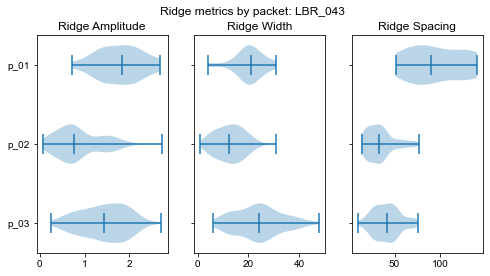

In [20]:
ridge_metrics = violin_data(itx_packets)
sorted_packet_ids = itx_packets.index.get_level_values(0).unique().sort_values(ascending=False).values

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 4))

# Plot 1 - Amps
ax1.violinplot([ridge_metrics["ridge_amp"][i] for i in sorted_packet_ids], vert=False, showmedians=True)

ax1.set_yticks(range(1, 4))
ax1.set_yticklabels(sorted_packet_ids)
ax1.set_title("Ridge Amplitude")

# Plot 2 - Width
ax2.violinplot([ridge_metrics["ridge_width"][i] for i in sorted_packet_ids], vert=False, showmedians=True)

ax2.set_yticks(range(1, 4))
ax2.set_yticklabels([])
ax2.set_title("Ridge Width")

# Plot 1 - Amps
ax3.violinplot([ridge_metrics["pre_mig_dist"][i] for i in sorted_packet_ids], vert=False, showmedians=True)

ax3.set_yticks(range(1, 4))
ax3.set_yticklabels([])
ax3.set_title("Ridge Spacing")
plt.suptitle(f"Ridge metrics by packet: {bend_id}")
plt.savefig(f"/Users/avan/FLUD/BrazosScrolls/figures/RidgeMetricsWithinPackets_{bend_id}.png", dpi=200)

## LBR_077

In [21]:
bend_id = "LBR_077"
dem = rasterio.open("/Users/avan/FLUD/BrazosScrolls/data/raster/dem/sb_4_077_clip.tif")
bin_raster = rasterio.open("/Users/avan/FLUD/BrazosScrolls/data/r10/agreement-clip-denoise/sb_4_077_agreement_45px_binclass_clip_dn_Buff100m_SmFt500m_ET80p.tif")

bend_ds = BendDataset(bend_id)
transects = bend_ds.get_transects(proj=True)
ridges = bend_ds.get_ridges(proj=True)
packets = bend_ds.get_packets(proj=True)
packets["centroid"] = packets.centroid


In [22]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", ShapelyDeprecationWarning)
    rich_transects, itx = calculate_ridge_metrics(transects, bin_raster, dem, ridges)

# Additional processes that need to be integrated upstream
itx = itx.droplevel(0)
itx["pre_mig_geometry"] = itx["substring_geometry"].apply(lambda x: LineString(x.coords[1:]))
itx_packets = join_packet_info(itx, packets)
itx_packets = calc_component_geometries(itx_packets)
packets = calc_mean_comp_distances(packets, itx_packets)

Started BDE
Started TDE for t_003
Started RDE
Started RDE
Started TDE for t_005
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_006
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_007
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_008
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_009
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_010
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_011
Started RDE
Started RDE
Started RDE
Started 

/Users/avan/opt/miniconda3/envs/scroll/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/avan/opt/miniconda3/envs/scroll/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


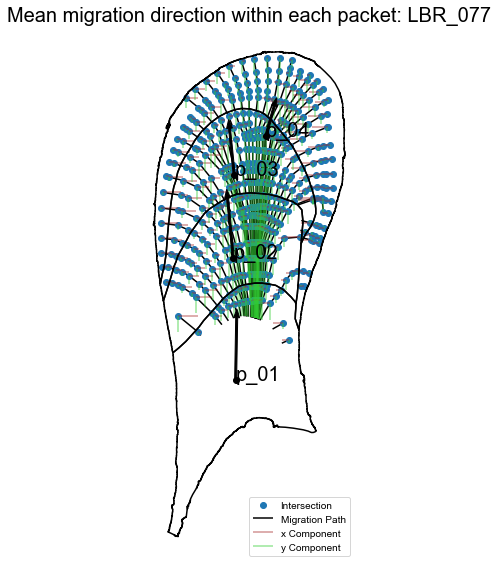

In [23]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

# Plot points and thier component directions
itx_packets.plot(ax=ax, zorder=2, label="Intersection")
itx_packets.set_geometry("pre_mig_geometry").plot(ax=ax, color="k", zorder=1, label="Migration Path")
itx_packets.set_geometry("x_comp_geometry").plot(ax=ax, color="brown", alpha=0.5, label="x Component")
itx_packets.set_geometry("y_comp_geometry").plot(ax=ax, color="limegreen", alpha=0.5, label="y Component")

# Plot packets
packets.boundary.plot(ax=ax, color="k")
packets.set_geometry("centroid").plot(ax=ax, color="k", zorder=3)

# Plot arrows showing the mean component direction
for i, row in packets.iterrows():
    x, y = row["centroid"].coords[0]
    plt.arrow(x, y, -row["x_comp_distance"]*5, -row["y_comp_distance"]*5, width=9, color="k", zorder=3)

# Plot packet labels
for idx, row in packets.iterrows():
    plt.annotate(text=idx, xy=row["centroid"].coords[0],
                 horizontalalignment='left', size=20)

ax.set_title(f"Mean migration direction within each packet: {bend_id}", size=20)
ax.legend(loc="lower right")
ax.set_axis_off()
plt.tight_layout()
plt.savefig(f"/Users/avan/FLUD/BrazosScrolls/figures/MigrationDirectionWithinPackets_{bend_id}.png", dpi=200)

/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_53659/371854471.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  vals = itx_packets.loc[p_id, name].values
/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_53659/371854471.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  vals = itx_packets.loc[p_id, name].values
/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_53659/371854471.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  vals = itx_packets.loc[p_id, name].values
/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_53659/371854471.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  vals = itx_packets.loc[p_id, name].values
/var/folders/bl/pshn9drx0bb1h4fsg0dytv0w0000gn/T/ipykernel_53659/371854471.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  vals = itx_packets.loc[p_id, name].values
/var/folde

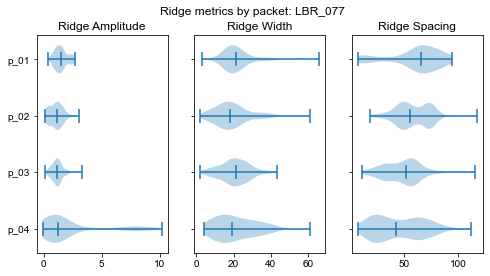

In [24]:
ridge_metrics = violin_data(itx_packets)
sorted_packet_ids = itx_packets.index.get_level_values(0).unique().sort_values(ascending=False).values

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 4))

# Plot 1 - Amps
ax1.violinplot([ridge_metrics["ridge_amp"][i] for i in sorted_packet_ids], vert=False, showmedians=True)

ax1.set_yticks(range(1, 5))
ax1.set_yticklabels(sorted_packet_ids)
ax1.set_title("Ridge Amplitude")

# Plot 2 - Width
ax2.violinplot([ridge_metrics["ridge_width"][i] for i in sorted_packet_ids], vert=False, showmedians=True)

ax2.set_yticks(range(1, 5))
ax2.set_yticklabels([])
ax2.set_title("Ridge Width")

# Plot 1 - Amps
ax3.violinplot([ridge_metrics["pre_mig_dist"][i] for i in sorted_packet_ids], vert=False, showmedians=True)

ax3.set_yticks(range(1, 5))
ax3.set_yticklabels([])
ax3.set_title("Ridge Spacing")
plt.suptitle(f"Ridge metrics by packet: {bend_id}")
plt.savefig(f"/Users/avan/FLUD/BrazosScrolls/figures/RidgeMetricsWithinPackets_{bend_id}.png", dpi=200)